In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

import zarr
import xarray as xr
import os
from sklearn import preprocessing
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.nn import Linear, Conv1d, ConvTranspose1d

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.functional import F
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm

from tqdm.notebook import tqdm
import json

In [2]:
from models import DriverDatasets, VAElatentdynamics

## Load the Datasets

In [3]:
trainloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/trainloader_onecat.pth')
valloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/valloader_onecat.pth')
testloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/testloader_onecat.pth')

In [5]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()
    mse = mseloss(recon_x,x)

    return mse
def vae_loss(recon_x,x,mu,logvar):
    mseloss = torch.nn.MSELoss()

    reconloss = mseloss(recon_x,x)
    
    kldweight = 1e-6
    kldloss = torch.mean(-0.5*torch.sum(1+logvar-mu**2-logvar.exp(),dim=1),dim=0)
    
    loss = reconloss+kldweight*kldloss
    
    return loss

In [6]:
a0 = 1 
b = 1e0
c = 1e2
d = 1e0

def train(model,dataloader,criterion,device,epoch):
    model.train()
    
    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal 

        bin0 = bin0.to(device)
        bin1 = bin1.to(device)
        binmag = binmag.to(device)
        bs = bin1.size(0)

        optimizer.zero_grad()

        normRt0,normRt1,Lit1,Lit1_pred,binmagRt0,binmagRt1,Lit0,mu0,logvar0,mu1,logvar1 = model(torch.Tensor(bin0).float(),
                            torch.Tensor(bin1).float(),binmag[:,0:2].float(),binmag[:,2:4].float())

        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
        normbin1 = bin1.float()*torch.broadcast_to(binmag[:,2:4].float().unsqueeze(dim=2),(bs,2,35))
            
        Rloss0 = vae_loss(normRt0,normbin0,mu0,logvar0)
        Rloss1 = vae_loss(normRt1,normbin1,mu1,logvar1) 
        
        Lloss = recon_loss(Lit1,Lit1_pred)+d*recon_loss((Lit1-Lit0)**2,(Lit1_pred-Lit0)**2)

        loss = a0*Rloss0+b*Rloss1+c*Lloss

        loss.backward()

        optimizer.step()
        
    return model
def test(model,dataloader,criterion,device,val=False):
    model.eval()
    correct = 0
    R0all = 0
    R1all = 0
    Lall = 0
    losstot = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
            bin1 = bin1coal
            bin0 = bin0.to(device)
            bin1 = bin1.to(device)
            binmag = binmag.to(device)
        
            bs = bin1.size(0)
            normRt0,normRt1,Lit1,Lit1_pred,binmagRt0,binmagRt1,Lit0,mu0,logvar0,mu1,logvar1 = model(torch.Tensor(bin0).float(),
                        torch.Tensor(bin1).float(),binmag[:,0:2].float(),binmag[:,2:4].float())
            
            normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
            normbin1 = bin1.float()*torch.broadcast_to(binmag[:,2:4].float().unsqueeze(dim=2),(bs,2,35))
            
            Rloss0 = vae_loss(normRt0,normbin0,mu0,logvar0)
            Rloss1 = vae_loss(normRt1,normbin1,mu1,logvar1) 
            Lloss = recon_loss(Lit1,Lit1_pred)+d*recon_loss((Lit1-Lit0)**2,(Lit1_pred-Lit0)**2)
        
            lossall = a0*Rloss0+b*Rloss1+c*Lloss
            
            nn = len(dataloader.dataset)
            R0all = R0all+Rloss0
            R1all = R1all+Rloss1
            Lall = Lall+Lloss
            losstot = losstot+lossall
            
        if val==True:
            sched.step(losstot/nn)

        return losstot/nn,R0all/nn,R1all/nn,Lall/nn

def inference(model,dataloader,device,nlatent,singlecat=True):
    model.eval()
    dataset = dataloader.dataset

    ntargets = nlatent #+2
    nmoms = 4
    nrates = 3
    bs = 500
    print(len(dataset))
    
    pred = np.zeros((len(dataset),ntargets,nrates))
    real = np.zeros((len(dataset),ntargets,nrates))
    
    #[500, 3, 3, 2]) torch.Size([500, 3, 3, 2] 
    if singlecat:
        realM = np.zeros((len(dataset),nmoms,nrates))
        realdMdt = np.zeros((len(dataset),nmoms,nrates))
    else:
        realM = np.zeros((len(dataset),3,3,2))
        realdMdt = np.zeros((len(dataset),3,3,2))    
    
    
    realbin1 = np.zeros((len(dataset),2,35))
    realbin0 = np.zeros((len(dataset),2,35))
    predbin0 = np.zeros((len(dataset),2,35))
    predbin1 = np.zeros((len(dataset),2,35))
 
    Lt0= np.zeros((len(dataset),ntargets))
    predL = np.zeros((len(dataset),ntargets))
    realL = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0

    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal 
        bin0 = bin0.to(device)
        bin1 = bin1.to(device)
        binmag = binmag.to(device)
        
        normRt0,normRt1,Lit1,Lit1_pred,binmagRt0,binmagRt1,Lit0,mu0,logvar0,mu1,logvar1 = model(torch.Tensor(bin0).float(),
                        torch.Tensor(bin1).float(),binmag[:,0:2].float(),binmag[:,2:4].float())
        bs = normRt0.size(0)
        
        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
        normbin1 = bin1.float()*torch.broadcast_to(binmag[:,2:4].float().unsqueeze(dim=2),(bs,2,35))
        
        if normRt0 is not(None):
            if singlecat:
                realM[jj:jj+bs,:,:] = M1.cpu().detach().numpy().reshape(bs,nmoms,nrates)
                realdMdt[jj:jj+bs,:,:] = dM1dt.cpu().detach().numpy().reshape(bs,nmoms,nrates)
            else:
                realM[jj:jj+bs,:,:] = M2.cpu().detach().numpy().reshape(bs,3,3,2)
                realdMdt[jj:jj+bs,:,:] = dM2dt.cpu().detach().numpy().reshape(bs,3,3,2)
            realbin0[jj:jj+bs,:] = normbin0.cpu().detach().numpy().reshape(bs,2,35)
            realbin1[jj:jj+bs,:] = normbin1.cpu().detach().numpy().reshape(bs,2,35)
            predbin0[jj:jj+bs,:] = normRt0.cpu().detach().numpy().reshape(bs,2,35)
            predbin1[jj:jj+bs,:] = normRt1.cpu().detach().numpy().reshape(bs,2,35)
            predL[jj:jj+bs,:] = Lit1_pred.cpu().detach().numpy().reshape(bs,ntargets)
            realL[jj:jj+bs,:] = Lit1.cpu().detach().numpy().reshape(bs,ntargets)
            Lt0[jj:jj+bs,:] = Lit0.cpu().detach().numpy().reshape(bs,ntargets)
            
            jj=jj+bs
            i = i+1
        else:
            break

    return realM,realdMdt,realbin0,realbin1,predbin0,predbin1,predL,realL,Lt0

## Train the model for 10 random initializations

In [8]:
n_rep = 10

for j in range(0,n_rep):
    print("Training model n = ",str(j))
    init_lr = 1e-3
    weight_decay = 1e-3
    #total_epochs = 1000

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    model = VAElatentdynamics(n_bins=35,n_latent=3,n_hidden=20)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)

    sched =  ReduceLROnPlateau(optimizer, 'min')
    criterion = torch.nn.MSELoss()
    
    val_loss_all = []
    train_loss_all = []

    val_R0_all = []
    train_R0_all = []

    val_R1_all = []
    train_R1_all = []

    val_L_all = []
    train_L_all = []
    
    e0 = 0
    epochs = 500
    best_epoch = 0
    
    min_loss = 1e10

    for epoch in tqdm(range(e0,epochs)):
        mod = train(model,trainloader,criterion,device,epoch)
        train_loss,train_R0,train_R1,train_L = test(model,trainloader,criterion,device)
        val_loss,val_R0,val_R1,val_L = test(model,valloader,criterion,device,val=True)
    
        train_loss_all.append(train_loss.cpu())
        val_loss_all.append(val_loss.cpu())
    
        train_R0_all.append(train_R0.cpu())
        val_R0_all.append(val_R0.cpu())
    
        train_R1_all.append(train_R1.cpu())
        val_R1_all.append(val_R1.cpu())    
    
        train_L_all.append(train_L.cpu())
        val_L_all.append(val_L.cpu())
    
        if epoch%50==0:
            print(f'{epoch:03d}, Train: {train_loss:.8e}, Val.: {val_loss:.8e}')
            
        if val_loss<min_loss:
            bestmodel = model
            min_loss = val_loss
            best_epoch = epoch
    tmp_trainloss = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2_losses.npz".format(j,epochs)
    
    mod_weights = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2".format(j,epochs)
    
    print(tmp_trainloss)
    print(mod_weights)
    print(best_epoch)
    
    torch.save(bestmodel.state_dict(),mod_weights)
    
    train_loss_np = np.array(train_loss_all)
    val_loss_np = np.array(val_loss_all)
    
    train_R0_np = np.array(train_R0_all)
    val_R0_np = np.array(val_R0_all)
    
    train_R1_np = np.array(train_R1_all)
    val_R1_np = np.array(val_R1_all)
    
    train_L_np = np.array(train_L_all)
    val_L_np = np.array(val_L_all)
    
    np.savez(tmp_trainloss,trainl=train_loss_np,vall=val_loss_np,trainr0 = train_R0_np, valr0 = val_R0_np, train_r1 = train_R1_np, val_r1 = val_R1_np, train_lin = train_L_np, val_lin = val_L_np)

Training model n =  0
Training model n =  1
Training model n =  2
Training model n =  3
Training model n =  4
Training model n =  5
Training model n =  6
Training model n =  7
Training model n =  8
Training model n =  9


In [9]:
val_loss_all = []
train_loss_all = []

val_R0_all = []
train_R0_all = []

val_R1_all = []
train_R1_all = []

val_L_all = []
train_L_all = []

n_rep = 10
epoch = 499
epochs = 500
for j in range(0,n_rep):
    fnloss = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2_losses.npz".format(j,epochs)
        
    loss = np.load(fnloss)
    train_loss_all.append(loss['trainl'])
    val_loss_all.append(loss['vall'])
    
    val_R0_all.append(loss['trainr0'])
    train_R0_all.append(loss['valr0'])

    val_R1_all.append(loss['train_r1'])
    train_R1_all.append(loss['val_r1'])

    val_L_all.append(loss['train_lin'])
    train_L_all.append(loss['val_lin'])
    
    trainl = loss['trainl'][-1]
    vall = loss['vall'][-1]
    valr0 = loss['valr0'][-1]
    val_r1 = loss['val_r1'][-1]
    train_lin = loss['train_lin'][-1]
    val_lin = loss['val_lin'][-1]
    
    print(f'{j:02d}, {epoch:03d}, Train: {trainl:.8e}, Val.: {vall:.8e}, Val R0: {valr0:.8e}, Val. R1: {val_r1:.8e}, Tr. L: {train_lin:.8e}, Val. L: {val_lin:.8e}')


00, 499, Train: 6.92866081e-07, Val.: 7.04305421e-07, Val R0: 3.40603719e-07, Val. R1: 3.39958177e-07, Tr. L: 2.30934175e-10, Val. L: 2.37436404e-10
01, 499, Train: 7.66758490e-07, Val.: 7.84807412e-07, Val R0: 3.87104052e-07, Val. R1: 3.86858090e-07, Tr. L: 1.05632822e-10, Val. L: 1.08453226e-10
02, 499, Train: 4.51334614e-07, Val.: 4.63983724e-07, Val R0: 2.28044996e-07, Val. R1: 2.27873144e-07, Tr. L: 7.98318911e-11, Val. L: 8.06551770e-11
03, 499, Train: 6.19825698e-07, Val.: 6.32519914e-07, Val R0: 3.09316249e-07, Val. R1: 3.08937757e-07, Tr. L: 1.31234176e-10, Val. L: 1.42658496e-10
04, 499, Train: 4.17449826e-07, Val.: 4.27494683e-07, Val R0: 2.08905107e-07, Val. R1: 2.08721062e-07, Tr. L: 9.48583434e-11, Val. L: 9.86850532e-11
05, 499, Train: 4.40816990e-07, Val.: 4.50609178e-07, Val R0: 2.19768637e-07, Val. R1: 2.19571902e-07, Tr. L: 1.07496692e-10, Val. L: 1.12686679e-10
06, 499, Train: 4.31109044e-07, Val.: 4.45230569e-07, Val R0: 2.16828283e-07, Val. R1: 2.16599062e-07, Tr.

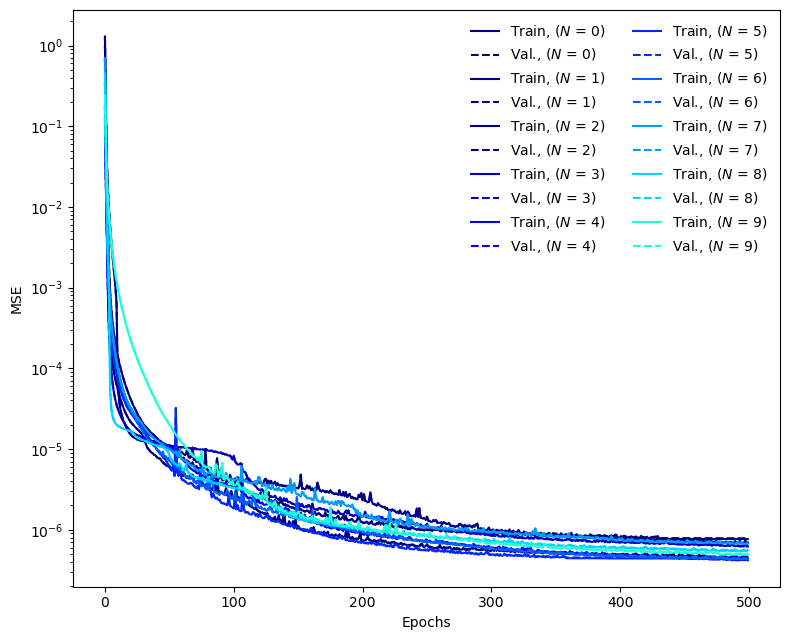

In [10]:
trainloss = []
valloss = []

n_rep=10
fig = plt.figure(figsize=(8,6.5))
norm = matplotlib.colors.Normalize(vmin=2.0, vmax=20.0)
cols = cm.jet(norm(np.arange(0,n_rep)),bytes=True)/256

for j in range(0,n_rep):
    epochs = 500
    
    fnloss = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2_losses.npz".format(j,epochs)
    loss = np.load(fnloss)
    trainloss.append(loss['trainl'])
    valloss.append(loss['vall'])
    
    plt.plot(trainloss[j],label=r"Train, ($N$ = "+str(j)+")",c = tuple(cols[j]))
    plt.plot(valloss[j],label=r"Val., ($N$ = "+str(j)+")", linestyle='dashed',c = tuple(cols[j]))

plt.legend(loc='upper right',ncol=2,frameon=False)
plt.yscale('log')
plt.ylabel("MSE")
plt.xlabel("Epochs")
#plt.show()
plt.tight_layout()
#plt.savefig("MSELoss_LatentDynamics_10reps.png")

In [19]:
from scipy.stats import wasserstein_distance
import pandas as pd

In [20]:
def kl_divergence(p, q):
    #q = q+1e-14
    #p = p+1e-14
    
    q = q/(np.sum(q,keepdims=True)+1e-14)
    p = p/(np.sum(p,keepdims=True)+1e-14)
    
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def mse(p, q):

    return np.sum((p-q)**2)/len(p)

def wasserstein(a,b):
    a = a/(np.sum(a,keepdims=True)+1e-14)
    b = b/(np.sum(b,keepdims=True)+1e-14)
    
    cdf_a = np.cumsum(a)
    cdf_b = np.cumsum(b)

    return wasserstein_distance(cdf_a,cdf_b)

In [21]:
def calcwasserstein(bina,binb):
    bina = bina/(np.sum(bina,axis=1,keepdims=True)+1e-14)
    binb = binb/(np.sum(binb,axis=1,keepdims=True)+1e-14)
    
    cdf_a = np.cumsum(bina,axis=1)
    cdf_b = np.cumsum(binb,axis=1)
    
    dist = np.zeros(cdf_a.shape[0])
    distkl = np.zeros(cdf_a.shape[0])
    distmse = np.zeros(cdf_a.shape[0]) 
    for i in range(0,cdf_a.shape[0]):
        dist[i]=wasserstein_distance(cdf_a[i,:],cdf_b[i,:])
        distkl[i]=kl_divergence(bina[i,:],binb[i,:])
        distmse[i]=mse(bina[i,:],binb[i,:])
    return dist,distkl,distmse

In [22]:
n_rep = 10
n_test = len(testloader.dataset)

wdistances = np.zeros((n_rep,n_test,2))
kldistances = np.zeros((n_rep,n_test,2))
msedistances = np.zeros((n_rep,n_test,2))

realizations = np.ones((n_rep,n_test))

wdistrep = np.zeros((n_rep,2))
kldistrep = np.zeros((n_rep,2))
msedistrep = np.zeros((n_rep,2))

for j in range(0,n_rep):
    print("Training model n = ",str(j))

    nlatent = 3
    sc = True
    
    model = VAElatentdynamics(n_bins=35,n_latent=3,n_hidden=20)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)
    #print(model)
    model = model.to(device)

    mod_weights = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2".format(j,epochs)

    model.load_state_dict(torch.load(mod_weights))
    
    testM,testdMdt,testrealbin0,testrealbin1,testpredbin0,testpredbin1,testpredL,testrealL,testrealL0=inference(model,testloader,device,nlatent,singlecat=sc)
    wdistances[j,:,0],kldistances[j,:,0],msedistances[j,:,0]=calcwasserstein(testrealbin0[:,0,:],testpredbin0[:,0,:])
    wdistances[j,:,1],kldistances[j,:,1],msedistances[j,:,1]=calcwasserstein(testrealbin0[:,1,:],testpredbin0[:,1,:])  
    realizations[j,:]=np.ones(n_test)*j
    
    wdistrep[j,0] = np.mean(wdistances[j,:,0])
    wdistrep[j,1] = np.std(wdistances[j,:,1])
    kldistrep[j,0] = np.mean(kldistances[j,:,0])
    kldistrep[j,1] = np.mean(kldistances[j,:,1])
    msedistrep[j,0] = np.mean(msedistances[j,:,0])
    msedistrep[j,1] = np.mean(msedistances[j,:,1])
    
    d = {r"Wasserstein Dist. ($l_{1}$)":np.log(wdistances[j,:,0]),'KL-Div.':np.log(kldistances[j,:,0]),"MSE": np.log(msedistances[j,:,0]),"Realization":realizations[j,:].astype(int)}
    df = pd.DataFrame(data=d)
    
    if j==0:
        latentdf = df
    else:
        latentdf = pd.concat([latentdf,df])
    
print("MSE: ", np.mean(msedistances[j,:,0].flatten()),np.std(msedistances[j,:,0].flatten()))
print("KL: ", np.mean(kldistances[j,:,0].flatten()),np.std(kldistances[j,:,0].flatten()))
print("Wasserstein: ", np.mean(wdistances[j,:,0].flatten()),np.std(wdistances[j,:,0].flatten()))

Training model n =  0
26214


/tmp/ipykernel_4479/2147665654.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipykernel_4479/2147665654.py:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipykernel_4479/2147665654.py:8: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipykernel_4479/3331754779.py:44: RuntimeWarning: divide by zero encountered in log
  d = {r"Wasserstein Dist. ($l_{1}$)":np.log(wdistances[j,:,0]),'KL-Div.':np.log(kldistances[j,:,0]),"MSE": np.log(msedistances[j,:,0]),"Realization":realizations[j,:].astype(int)}


Training model n =  1
26214
Training model n =  2
26214
Training model n =  3
26214


/tmp/ipykernel_4479/2147665654.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


Training model n =  4
26214
Training model n =  5
26214
Training model n =  6
26214
Training model n =  7
26214
Training model n =  8
26214
Training model n =  9
26214
MSE:  0.00025902686145247374 0.0005056912015350612
KL:  0.4511654378224328 0.8742173685228962
Wasserstein:  0.01205014139871765 0.01503374462935939


In [23]:
np.save("recmetrics/latentwasserstein",wdistrep)
np.save("recmetrics/latentkl",kldistrep)
np.save("recmetrics/latentmse",msedistrep)

In [24]:
latentdf.to_csv("recmetrics/latentdf.csv")